In [47]:
# System and warnings
import os
import warnings
import time
import json
import pickle
import joblib
from datetime import datetime

# Data handling
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import HTML, display
from scipy.stats import kendalltau

# Sklearn - preprocessing, models, metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.calibration import CalibratedClassifierCV

# Advanced models
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Deep Learning (TensorFlow/Keras)
from tensorflow.keras.models import Sequential, load_model as keras_load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from scikeras.wrappers import KerasClassifier

# Model explanation
import shap
import lime
import lime.lime_tabular

# Parallel processing
from joblib import Parallel, delayed, dump

# Twillio
from dotenv import load_dotenv
from twilio.rest import Client

load_dotenv()

# ================= Suppress Warnings =================
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', module='xgboost')
warnings.filterwarnings('ignore', module='lightgbm')
warnings.filterwarnings('ignore', category=FutureWarning)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppress TensorFlow warnings


In [24]:
# Twillio ENV Variables
TWILIO_ACCOUNT_SID = os.getenv("TWILIO_ACCOUNT_SID")
TWILIO_AUTH_TOKEN = os.getenv("TWILIO_AUTH_TOKEN")
TWILIO_WHATSAPP_FROM = os.getenv("TWILIO_WHATSAPP_FROM")
TWILIO_WHATSAPP_TO = os.getenv("TWILIO_WHATSAPP_TO")

In [25]:
DOCS_DIR = './docs'  
MODEL_DIR = './models'
sample_file = f'{DOCS_DIR}/preprocessed_data.csv'

os.makedirs(MODEL_DIR, exist_ok=True)

In [26]:
def load_model(model_name, models_dir="./models"):
    """
    Load the saved scaler, model (including DNN .h5), and label encoder by name.

    Parameters:
    model_name (str): Name of the model (e.g., 'Random Forest', 'DNN')
    models_dir (str): Directory where models are saved

    Returns:
    tuple: (scaler, model, label_encoder)
    """
    # Determine model path
    if model_name == "DNN" or model_name == "dnn":
        model_path = os.path.join(models_dir, "dnn.h5")
    else:
        model_filename = f"{model_name.replace(' ', '_').lower()}.pkl"
        model_path = os.path.join(models_dir, model_filename)

    scaler_path = os.path.join(models_dir, "scaler.pkl")
    label_encoder_path = os.path.join(models_dir, "label_encoder.pkl")

    # Check file existence
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"❌ Model file not found: {model_path}")
    if not os.path.exists(scaler_path):
        raise FileNotFoundError(f"❌ Scaler file not found: {scaler_path}")
    if not os.path.exists(label_encoder_path):
        raise FileNotFoundError(f"❌ LabelEncoder file not found: {label_encoder_path}")

    # Load all artifacts
    scaler = joblib.load(scaler_path)
    if model_name == "DNN" or model_name == 'dnn':
        model = keras_load_model(model_path)
    else:
        model = joblib.load(model_path)

    with open(label_encoder_path, "rb") as f:
        le = pickle.load(f)

    return scaler, model, le

# 💡 Usage example
print("\n💡 To load a saved model, scaler, and label encoder, use:")
print("   scaler, model, le = load_model('Random Forest')")


💡 To load a saved model, scaler, and label encoder, use:
   scaler, model, le = load_model('Random Forest')


In [27]:
def compute_eci_shap(model, scaler, input_json, num_samples=10):
    """
    Generate ECI score using SHAP values across multiple perturbed inputs.
    """
    # Generate variations of input
    base_values = np.array(list(input_json.values()))
    feature_names = list(input_json.keys())

    # Create perturbed dataset
    np.random.seed(42)
    perturbations = np.random.normal(loc=0.0, scale=0.05, size=(num_samples, len(base_values)))
    input_matrix = base_values + base_values * perturbations
    input_matrix = pd.DataFrame(input_matrix, columns=feature_names)

    # Scale
    input_scaled = scaler.transform(input_matrix)

    # Explain with SHAP (Tree or Kernel based on model)
    if hasattr(model, "predict_proba"):  # Tree-based models
        explainer = shap.Explainer(model.predict, input_scaled)
    else:  # DNN model
        explainer = shap.KernelExplainer(model.predict, input_scaled)

    shap_values = explainer(input_scaled)
    shap_matrix = np.array([np.abs(shap_values[i].values) for i in range(num_samples)])

    # Rank features for each sample
    rankings = np.argsort(-shap_matrix, axis=1)  # descending order

    # Compute Kendall's Tau between pairs
    tau_matrix = np.zeros((num_samples, num_samples))

    for i in range(num_samples):
        for j in range(num_samples):
            tau, _ = kendalltau(rankings[i], rankings[j])
            tau_matrix[i, j] = tau

    # Calculate ECI (mean pairwise tau)
    triu_indices = np.triu_indices(num_samples, k=1)
    eci_score = np.nanmean(tau_matrix[triu_indices])

    # Visualization
    plt.figure(figsize=(8, 6))
    sns.heatmap(tau_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
    plt.title(f"🔁 Explanation Contribution Index (ECI) Matrix\nMean ECI: {eci_score:.4f}")
    plt.xlabel("Sample Index")
    plt.ylabel("Sample Index")
    plt.tight_layout()
    plt.show()

    return eci_score


In [30]:
def predict_input(input_json, model, scaler, le):
    """
    Predict the class of input data using a trained model (DNN or traditional).
    
    Parameters:
    - input_json: dict, input feature values
    - model: trained model (Keras or scikit-learn)
    - scaler: fitted scaler used during training
    - le: LabelEncoder used during training

    Returns:
    - predicted_class_name: str
    - predicted_label: int
    - y_proba: ndarray of class probabilities
    """
    feature_names = list(input_json.keys())
    input_df = pd.DataFrame([input_json])

    # Scale input
    input_scaled = scaler.transform(input_df)

    # Prediction handling
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(input_scaled)
        predicted_label = np.argmax(y_proba[0])
    else:
        y_proba = model.predict(input_scaled)
        if len(y_proba.shape) == 2 and y_proba.shape[1] > 1:  # Softmax from DNN
            predicted_label = np.argmax(y_proba[0])
        else:  # Binary class or label directly
            predicted_label = int(y_proba[0])
            y_proba = np.eye(len(le.classes_))[predicted_label].reshape(1, -1)

    predicted_class_name = le.inverse_transform([predicted_label])[0]

    # Display predictions
    print(f"\n🟢 Predicted Class: {predicted_label} ({predicted_class_name})")
    print(f"🔢 Prediction Probability: {y_proba[0][predicted_label]:.4f}\n")

    print("📊 All Class Probabilities (>1%):")
    for i, prob in enumerate(y_proba[0]):
        if prob > 0.01:
            print(f"  {le.inverse_transform([i])[0]:<25}: {prob:.4f}")

    return predicted_class_name, predicted_label, y_proba


In [50]:
df = pd.read_csv(sample_file)

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3014826 entries, 0 to 3014825
Data columns (total 16 columns):
 #   Column                      Dtype
---  ------                      -----
 0   flow_duration_milliseconds  int64
 1   protocol                    int64
 2   tcp_flags                   int64
 3   tcp_win_max_in              int64
 4   tcp_win_max_out             int64
 5   tcp_win_min_in              int64
 6   tcp_win_min_out             int64
 7   tcp_win_mss_in              int64
 8   tcp_win_scale_in            int64
 9   tcp_win_scale_out           int64
 10  total_flows_exp             int64
 11  in_bytes                    int64
 12  in_pkts                     int64
 13  out_bytes                   int64
 14  out_pkts                    int64
 15  label                       int64
dtypes: int64(16)
memory usage: 368.0 MB


In [24]:
x = df.iloc[:,:-1]
y = df.iloc[:,-1]

In [25]:
x

,flow_duration_milliseconds,protocol,tcp_flags,tcp_win_max_in,tcp_win_max_out,tcp_win_min_in,tcp_win_min_out,tcp_win_mss_in,tcp_win_scale_in,tcp_win_scale_out,total_flows_exp,in_bytes,in_pkts,out_bytes,out_pkts
0,7130,6,2,64240,0,64240,0,1460,7,0,356579549,240,4,0,0
1,0,6,22,1024,0,1024,0,1460,0,0,367378020,44,1,40,1
2,1,17,0,0,0,0,0,0,0,0,352013022,95,1,180,1
3,33,17,0,0,0,0,0,0,0,0,350798142,84,1,208,1
4,0,1,0,0,0,0,0,0,0,0,364558533,36,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3014821,1012,6,2,64240,0,64240,0,1460,7,0,369503013,120,2,0,0
3014822,0,6,2,65535,0,65535,0,0,0,0,364786722,40,1,0,0
3014823,0,6,22,1024,0,1024,0,1460,0,0,319367151,44,1,40,1
3014824,7199,6,2,64240,0,64240,0,1460,7,0,373989535,240,4,0,0


In [26]:
y

0          0
1          3
2          2
3          2
4          2
          ..
3014821    0
3014822    2
3014823    3
3014824    0
3014825    2
Name: label, Length: 3014826, dtype: int64

In [27]:
scaler = StandardScaler()

X_scaled = scaler.fit_transform(x) 

# Save the scaler
joblib.dump(scaler, f"{MODEL_DIR}/scaler.pkl")
print("Scaler saved to models/scaler.pkl")


Scaler saved to models/scaler.pkl


In [28]:
X_scaled

array([[ 0.10509019, -0.60235152, -0.47827124, ..., -0.0182807 ,
        -0.01745941, -0.02089551],
       [-0.27067682, -0.60235152,  0.84469678, ..., -0.02075232,
        -0.01744242, -0.0203026 ],
       [-0.27062412,  1.42592737, -0.61056804, ..., -0.02075232,
        -0.01738294, -0.0203026 ],
       ...,
       [-0.27067682, -0.60235152,  0.84469678, ..., -0.02075232,
        -0.01744242, -0.0203026 ],
       [ 0.10872665, -0.60235152, -0.47827124, ..., -0.0182807 ,
        -0.01745941, -0.02089551],
       [ 1.22026971, -0.60235152,  0.51395477, ..., -0.01992845,
        -0.01742033, -0.01970969]])

In [29]:


# Assuming X_scaled is already preprocessed and y contains labels
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)


In [30]:
total_samples = X_train.shape[0] + X_test.shape[0]
print("Total samples:", total_samples)
print("Training samples:", X_train.shape[0])
print("Test samples:", X_test.shape[0])

Total samples: 3014826
Training samples: 2411860
Test samples: 602966


In [31]:
# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [32]:
# Define DNN model creation function
def create_dnn(input_dim, output_dim):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_dim,)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(output_dim, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Define models (including LinearSVC and DNN)
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    "XGBoost": XGBClassifier(eval_metric='mlogloss', n_jobs=-1, random_state=42, verbosity=0),
    "LightGBM": LGBMClassifier(n_jobs=-1, random_state=42, verbose=-1, force_col_wise=True),
    "DNN": KerasClassifier(
        model=create_dnn,
        model__input_dim=X_train.shape[1],
        model__output_dim=len(np.unique(y_train_encoded)),
        epochs=20,
        batch_size=32,
        verbose=0
    )
}

print("Training models in parallel...\n")
model_items = list(models.items())

def train_and_evaluate_parallel(name, model, X_train, y_train, X_test, y_test_encoded):
    print(f"Training {name} in parallel...")
    try:
        start_time = time.time()
        # Handle DNN separately due to categorical labels
        if name == "DNN":
            y_train_cat = to_categorical(y_train)
            model.fit(X_train, y_train_cat)
            y_pred = model.predict(X_test)
            y_pred = np.argmax(y_pred, axis=1)  # Convert categorical to class labels
            model_filename = "dnn.h5"
            model_path = os.path.join(MODEL_DIR, model_filename)
            model.model_.save(model_path)  # Save Keras model as .h5
        else:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            model_filename = f"{name.replace(' ', '_').lower()}.pkl"
            model_path = os.path.join(MODEL_DIR, model_filename)
            dump(model, model_path)
        training_time = (time.time() - start_time) / 60
        acc = accuracy_score(y_test_encoded, y_pred)
        print(f"✓ {name} completed - Accuracy: {acc:.4f} - Training Time: {training_time:.2f} minutes - Saved to {model_path}")
        return {
            "Model": name,
            "Accuracy": acc,
            "Precision": precision_score(y_test_encoded, y_pred, average='macro', zero_division=0),
            "Recall": recall_score(y_test_encoded, y_pred, average='macro', zero_division=0),
            "F1-Score": f1_score(y_test_encoded, y_pred, average='macro', zero_division=0),
            "Path": model_path,
            "Training Time (minutes)": training_time
        }
    except Exception as e:
        print(f"Error training {name}: {e}")
        return None

try:
    results = Parallel(n_jobs=-1, verbose=10)(
        delayed(train_and_evaluate_parallel)(name, model, X_train, y_train_encoded, X_test, y_test_encoded)
        for name, model in model_items
    )
    # Filter out None results (in case of errors)
    results = [r for r in results if r is not None]
except Exception as e:
    print(f"Error during parallel training: {e}")

# Final results summary
model_paths = [{"Model": r["Model"], "Path": r["Path"]} for r in results]
print("\n" + "="*60)
print("MODEL EVALUATION RESULTS")
print("="*60)
results_df = pd.DataFrame(results).drop(columns="Path").sort_values(by="Accuracy", ascending=False)
print(results_df.to_string(index=False, float_format='%.4f'))
print(f"\nBest performing model: {results_df.iloc[0]['Model']}")
print(f"Best accuracy: {results_df.iloc[0]['Accuracy']:.4f}")

# Save results
results_path = os.path.join(MODEL_DIR, "model_evaluation_results.csv")
results_df.to_csv(results_path, index=False)
model_paths_df = pd.DataFrame(model_paths)
paths_path = os.path.join(MODEL_DIR,"model_paths.csv")
model_paths_df.to_csv(paths_path, index=False)

print("\n" + "="*60)
print("SAVED FILES")
print("="*60)
for model_info in model_paths:
    print(f"  • {model_info['Model']}: {model_info['Path']}")
print(f"\nResults summary saved to: {results_path}")
print(f"Model paths saved to: {paths_path}")
print(f"\n📁 All files saved in the '{MODEL_DIR}' directory")

Training models in parallel...



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   6 | elapsed:  4.1min remaining:  8.1min
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:  5.7min remaining:  5.7min
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:  5.8min remaining:  2.9min
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed: 47.1min finished



MODEL EVALUATION RESULTS
              Model  Accuracy  Precision  Recall  F1-Score  Training Time (minutes)
      Decision Tree    0.9994     0.9994  0.9805    0.9895                   2.0131
      Random Forest    0.9994     0.9993  0.9805    0.9895                   5.3546
            XGBoost    0.9992     0.9781  0.9612    0.9693                   6.6212
           LightGBM    0.9959     0.7451  0.7482    0.7466                   5.3901
                DNN    0.9951     0.9937  0.9979    0.9958                  46.7351
Logistic Regression    0.9871     0.9841  0.9938    0.9888                   3.6574

Best performing model: Decision Tree
Best accuracy: 0.9994

SAVED FILES
  • Logistic Regression: ./models\logistic_regression.pkl
  • Decision Tree: ./models\decision_tree.pkl
  • Random Forest: ./models\random_forest.pkl
  • XGBoost: ./models\xgboost.pkl
  • LightGBM: ./models\lightgbm.pkl
  • DNN: ./models\dnn.h5

Results summary saved to: ./models\model_evaluation_results.csv
Mod

In [28]:
mod_name = "Random Forest"
scaler, model, le = load_model(mod_name)        # Ensure this path is correct

# === Step 2: Define the input JSON - BOT ===
input_json =  {
        "flow_duration_milliseconds": 7130,
        "protocol": 6,
        "tcp_flags": 2,
        "tcp_win_max_in": 64240,
        "tcp_win_max_out": 0,
        "tcp_win_min_in": 64240,
        "tcp_win_min_out": 0,
        "tcp_win_mss_in": 1460,
        "tcp_win_scale_in": 7,
        "tcp_win_scale_out": 0,
        "total_flows_exp": 356579549,
        "in_bytes": 240,
        "in_pkts": 4,
        "out_bytes": 0,
        "out_pkts": 0
    }

In [31]:
# Get prediction results
predicted_class_name, predicted_label, y_proba = predict_input(input_json, model, scaler, le)
probability = y_proba[0][predicted_label] * 100
probability_str = f"{int(probability)}" if probability == 100 else f"{probability:.2f}"


🟢 Predicted Class: 0 (dos)
🔢 Prediction Probability: 1.0000

📊 All Class Probabilities (>1%):
  dos                      : 1.0000


#### Explaination usinig LIME

In [39]:
# === Normalize & Scaling ===
feature_names = list(input_json.keys())
input_df = pd.DataFrame([input_json])
input_scaled = scaler.transform(input_df)

# === Prediction ===
y_pred = model.predict(input_scaled)
y_proba = model.predict_proba(input_scaled)
predicted_label = y_pred[0]
predicted_class_name = le.inverse_transform([predicted_label])[0]

print(f"🟢 Predicted Class: {predicted_label} ({predicted_class_name})")
print(f"🔢 Prediction Probability: {y_proba[0][predicted_label]:.4f}\n")

print("📊 All Class Probabilities (>1%):")
for i, prob in enumerate(y_proba[0]):
    if prob > 0.01:
        print(f"  {le.inverse_transform([i])[0]:<25}: {prob:.4f}")

# === Generate Synthetic Training Data (only if real unavailable) ===
def generate_synthetic_data(n_samples=1000):
    np.random.seed(42)
    return pd.DataFrame([{
        "flow_duration_milliseconds": np.random.randint(100, 10000),
        "protocol": np.random.choice([6, 17]),  # TCP (6), UDP (17)
        "tcp_flags": np.random.choice([0, 1, 2, 16, 18]),  # SYN, ACK, FIN, etc.
        "tcp_win_max_in": np.random.randint(0, 65535),
        "tcp_win_max_out": np.random.randint(0, 65535),
        "tcp_win_min_in": np.random.randint(0, 65535),
        "tcp_win_min_out": np.random.randint(0, 65535),
        "tcp_win_mss_in": np.random.randint(500, 1460),
        "tcp_win_scale_in": np.random.randint(0, 14),  # window scaling factor
        "tcp_win_scale_out": np.random.randint(0, 14),
        "total_flows_exp": np.random.randint(1e6, 1e9),
        "in_bytes": np.random.randint(0, 10000),
        "in_pkts": np.random.randint(0, 100),
        "out_bytes": np.random.randint(0, 10000),
        "out_pkts": np.random.randint(0, 100)
    } for _ in range(n_samples)])

training_df = generate_synthetic_data()
training_scaled = scaler.transform(training_df)

# === LIME Explainer ===
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_scaled,
    feature_names=feature_names,
    class_names=list(le.classes_),  # Use LabelEncoder class names
    mode='classification',
    discretize_continuous=True,
    random_state=42
)

# === LIME Explanation ===
explanation = explainer.explain_instance(
    input_scaled[0],
    model.predict_proba,
    num_features=len(feature_names),
    top_labels=5
)

🟢 Predicted Class: 0 (dos)
🔢 Prediction Probability: 1.0000

📊 All Class Probabilities (>1%):
  dos                      : 1.0000


In [40]:
# === Explanation Display ===
exp_list = explanation.as_list(label=predicted_label)

print("\n🧠 LIME EXPLANATION")
print("-" * 60)
for feat, val in exp_list:
    direction = "↑ increases" if val > 0 else "↓ decreases"
    print(f"{feat:<35} | {val:>7.4f} ({direction} prediction)")




🧠 LIME EXPLANATION
------------------------------------------------------------
1.10 < tcp_win_scale_in <= 2.29     |  0.0027 (↑ increases prediction)
tcp_win_max_out <= 0.60             |  0.0026 (↑ increases prediction)
tcp_win_min_in > 0.95               |  0.0021 (↑ increases prediction)
out_pkts <= -0.01                   |  0.0018 (↑ increases prediction)
-0.54 < tcp_flags <= -0.48          |  0.0015 (↑ increases prediction)
in_pkts <= -0.00                    |  0.0015 (↑ increases prediction)
-0.01 < flow_duration_milliseconds <= 0.12 |  0.0015 (↑ increases prediction)
-7.69 < total_flows_exp <= 10.54    |  0.0014 (↑ increases prediction)
tcp_win_max_in > 0.94               |  0.0013 (↑ increases prediction)
in_bytes <= -0.01                   |  0.0013 (↑ increases prediction)
tcp_win_mss_in > 0.73               |  0.0012 (↑ increases prediction)
out_bytes <= -0.02                  |  0.0011 (↑ increases prediction)
tcp_win_min_out <= 0.57             |  0.0011 (↑ increases p

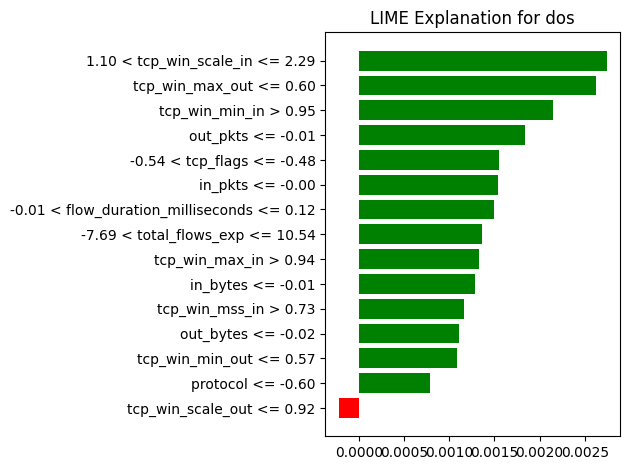

In [41]:
# === Plot LIME ===
fig = explanation.as_pyplot_figure(label=predicted_label)
plt.title(f'LIME Explanation for {predicted_class_name}')
plt.tight_layout()
plt.show()

In [42]:
# === HTML Output with Light Background ===
html_content = explanation.as_html(labels=[predicted_label])

display(HTML(html_content))

In [43]:
# === Summary: Top Contributing Features ===
print("\n🌟 TOP CONTRIBUTING FEATURES")
print("=" * 60)
for i, (feature, importance) in enumerate(sorted(exp_list, key=lambda x: abs(x[1]), reverse=True)[:5], 1):
    status = "SUPPORTS" if importance > 0 else "OPPOSES"
    print(f"{i}. {feature} → {importance:.4f} ({status} prediction)")


🌟 TOP CONTRIBUTING FEATURES
1. 1.10 < tcp_win_scale_in <= 2.29 → 0.0027 (SUPPORTS prediction)
2. tcp_win_max_out <= 0.60 → 0.0026 (SUPPORTS prediction)
3. tcp_win_min_in > 0.95 → 0.0021 (SUPPORTS prediction)
4. out_pkts <= -0.01 → 0.0018 (SUPPORTS prediction)
5. -0.54 < tcp_flags <= -0.48 → 0.0015 (SUPPORTS prediction)


In [44]:
# === Detailed Feature Impact ===
print("\n🔍 FEATURE VALUE ANALYSIS")
print("=" * 60)
for feat in feature_names:
    value = input_json[feat]
    impact = next((imp for f, imp in exp_list if feat in f), 0)
    print(f"{feat:<35}: {value:>10.2f} | LIME Impact: {impact:>8.4f}")


🔍 FEATURE VALUE ANALYSIS
flow_duration_milliseconds         :    7130.00 | LIME Impact:   0.0015
protocol                           :       6.00 | LIME Impact:   0.0008
tcp_flags                          :       2.00 | LIME Impact:   0.0015
tcp_win_max_in                     :   64240.00 | LIME Impact:   0.0013
tcp_win_max_out                    :       0.00 | LIME Impact:   0.0026
tcp_win_min_in                     :   64240.00 | LIME Impact:   0.0021
tcp_win_min_out                    :       0.00 | LIME Impact:   0.0011
tcp_win_mss_in                     :    1460.00 | LIME Impact:   0.0012
tcp_win_scale_in                   :       7.00 | LIME Impact:   0.0027
tcp_win_scale_out                  :       0.00 | LIME Impact:  -0.0002
total_flows_exp                    : 356579549.00 | LIME Impact:   0.0014
in_bytes                           :     240.00 | LIME Impact:   0.0013
in_pkts                            :       4.00 | LIME Impact:   0.0015
out_bytes                          :


📌 SHAP EXPLANATION


 95%|=================== | 3817/4000 [00:13<00:00]       

🔍 SHAP Input Shape: (1, 15, 4)
🔍 SHAP Train Shape: (1000, 15, 4)


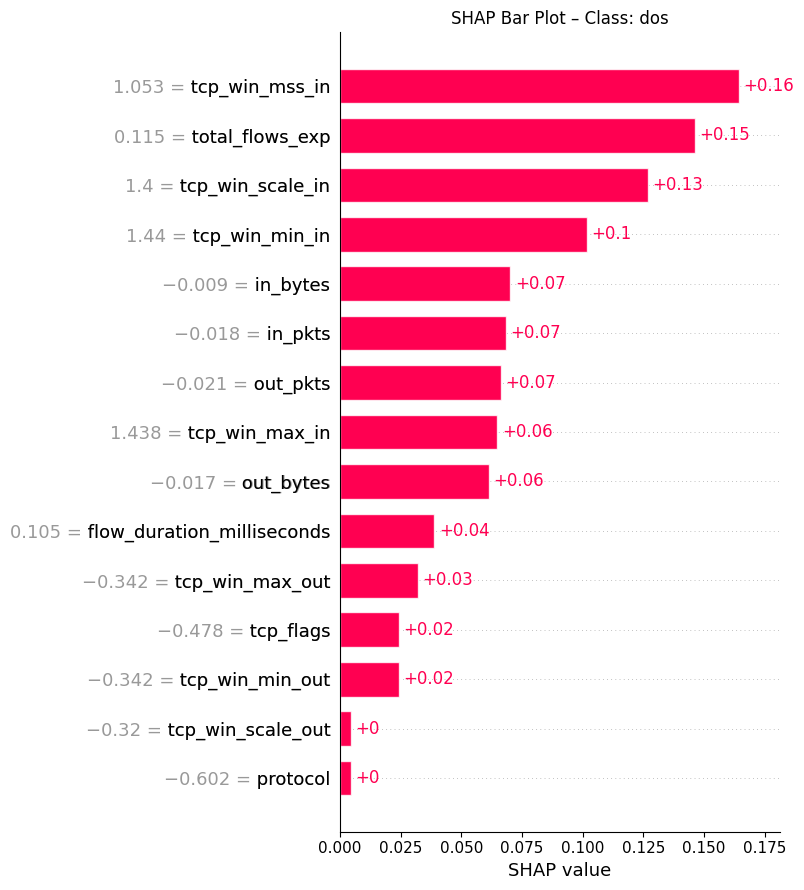

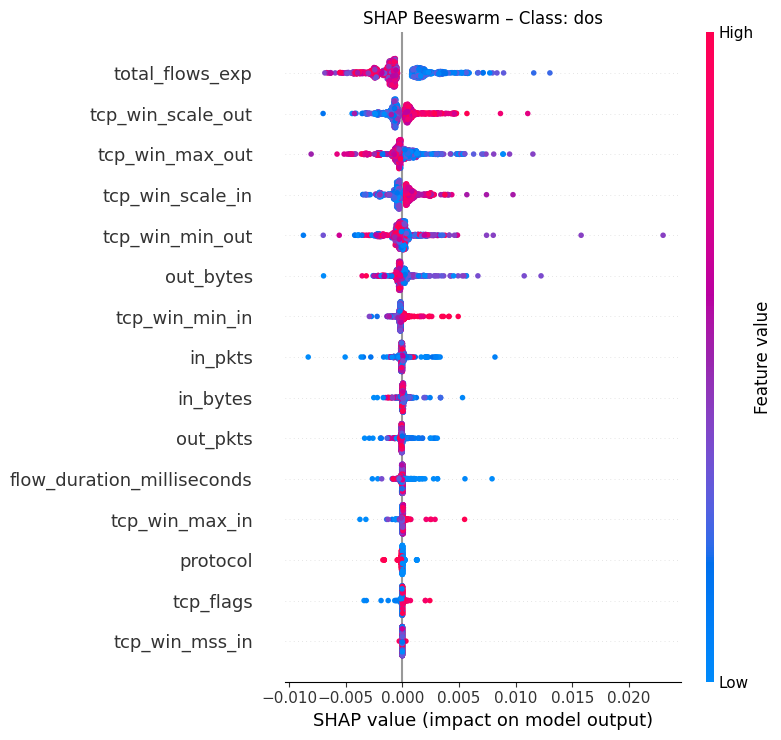

In [45]:

# === SHAP EXPLANATION ===
print("\n📌 SHAP EXPLANATION")
print("=" * 60)

# Use the correct SHAP explainer for non-tree models
explainer_shap = shap.Explainer(model, training_scaled,output_names=list(le.classes_),feature_names=feature_names)

# Compute SHAP values
shap_values_input = explainer_shap(input_scaled)
shap_values_train = explainer_shap(training_scaled)

print(f"🔍 SHAP Input Shape: {shap_values_input.shape}")
print(f"🔍 SHAP Train Shape: {shap_values_train.shape}")

# === Handle multi-class slicing safely ===
if len(shap_values_input.shape) == 3:
    # Predicted class index might be out of bounds, clamp it
    num_classes = shap_values_input.shape[2]
    safe_class_index = min(predicted_label, num_classes - 1)
    shap_values_input_class = shap_values_input[:, :, safe_class_index]
    shap_values_train_class = shap_values_train[:, :, safe_class_index]
else:
    shap_values_input_class = shap_values_input
    shap_values_train_class = shap_values_train

# === Bar Plot for Input Sample ===
plt.figure(figsize=(10, 5))
shap.plots.bar(shap_values_input_class[0], max_display=15, show=False)
plt.title(f"SHAP Bar Plot – Class: {predicted_class_name}")
plt.tight_layout()
plt.show()

# === Beeswarm Plot for Training Data ===
plt.figure(figsize=(10, 6))
shap.plots.beeswarm(shap_values_train_class, max_display=15, show=False)
plt.title(f"SHAP Beeswarm – Class: {predicted_class_name}")
plt.tight_layout()
plt.show()


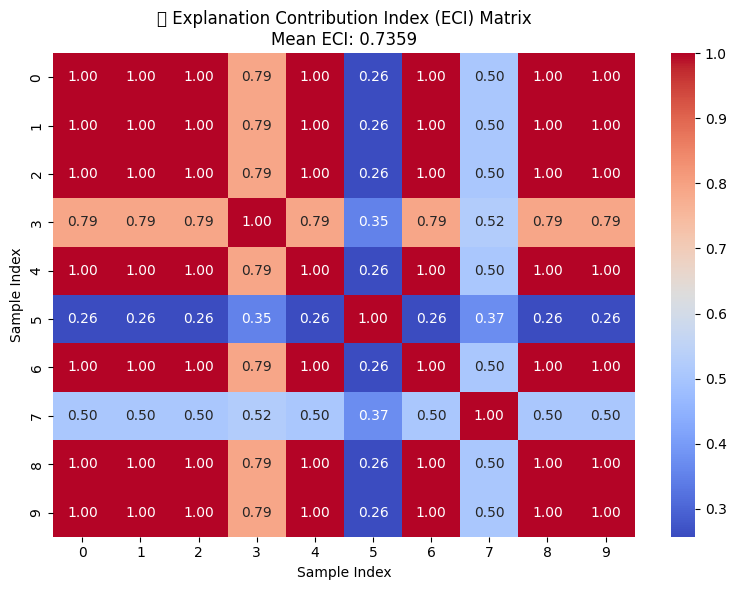


✅ Final ECI Score: 0.7359


In [48]:
eci = compute_eci_shap(model, scaler, input_json, num_samples=10)
print(f"\n✅ Final ECI Score: {eci:.4f}")

#### Whats app Notification

In [19]:
top_n = 5  # or 10
exp_list = explanation.as_list(label=predicted_label)[:top_n]

lime_msg = "\n".join([
    f"{i+1}. {feat} ({'+' if val > 0 else ''}{val:.4f})"
    for i, (feat, val) in enumerate(exp_list)
])


In [20]:
# Get shap values and feature names
shap_values_input_row = shap_values_input_class[0].values
shap_top_idx = np.argsort(np.abs(shap_values_input_row))[::-1][:top_n]

shap_msg = "\n".join([
    f"{i+1}. {feature_names[idx]} ({shap_values_input_row[idx]:+.4f})"
    for i, idx in enumerate(shap_top_idx)
])


In [21]:
# Format timestamp
timestamp = datetime.now().strftime("%Y-%m-%d %I:%M:%S %p")

content_variables = {
    "1": "CICIDS",
    "2": predicted_class_name,
    "3": mod_name,
    "4": probability_str,
    "5": lime_msg,
    "6": shap_msg,
    "7": timestamp
}


In [22]:
client = Client(TWILIO_ACCOUNT_SID, TWILIO_AUTH_TOKEN)

message = client.messages.create(
    from_=TWILIO_WHATSAPP_FROM,
    content_sid='HX0f2f25b0c4272fbca3c6f689ec703b66',
    content_variables=json.dumps(content_variables),
    to=TWILIO_WHATSAPP_TO
)

print(f"Message SID: {message.sid}")


Message SID: MM4f879d46231b8042fc2886c495319749


🔍 Evaluating: Logistic Regression
🔍 Evaluating: Decision Tree
🔍 Evaluating: Random Forest
🔍 Evaluating: XGBoost
🔍 Evaluating: LightGBM
🔍 Evaluating: DNN


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


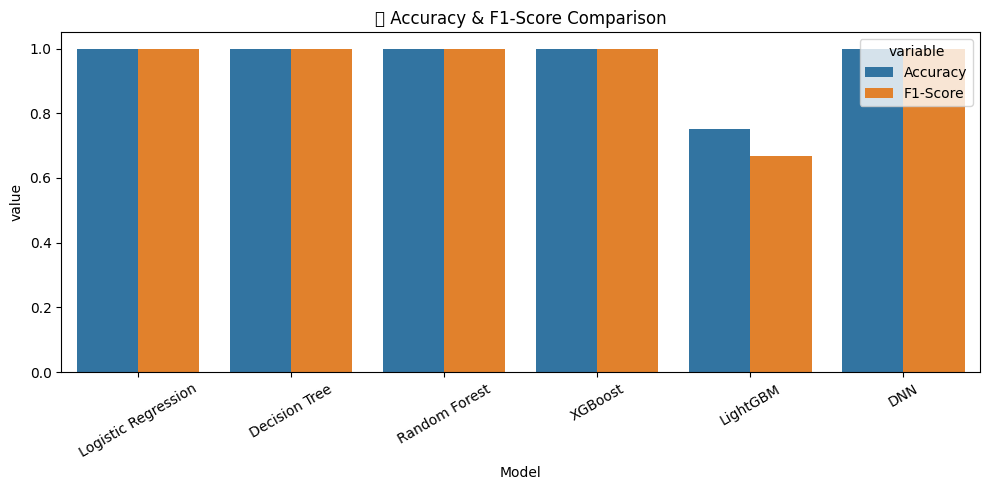

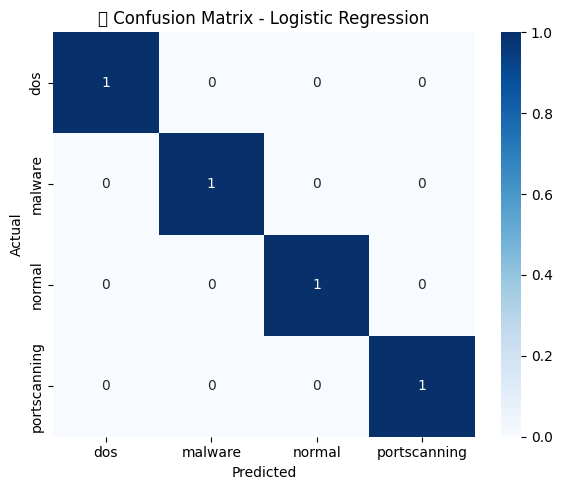

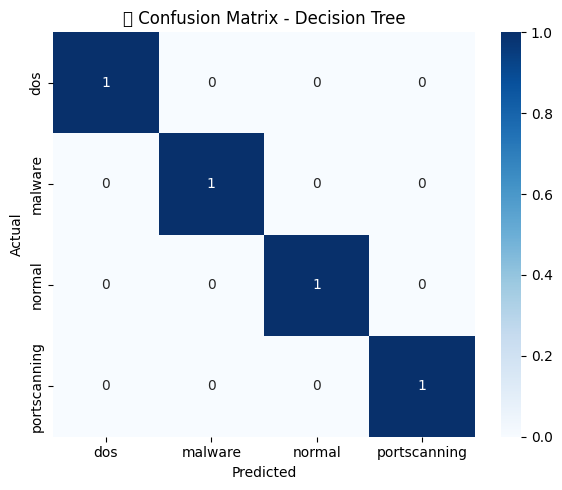

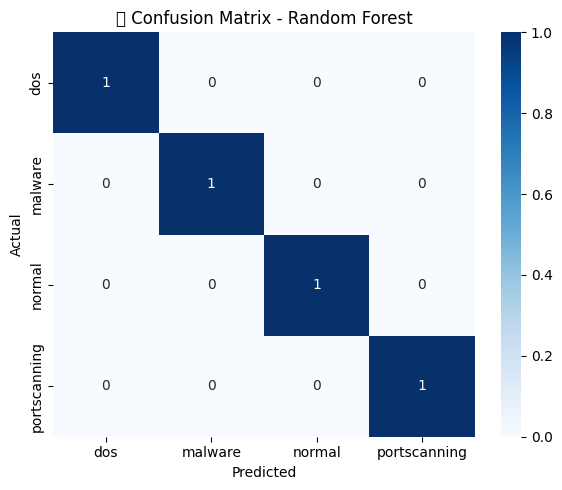

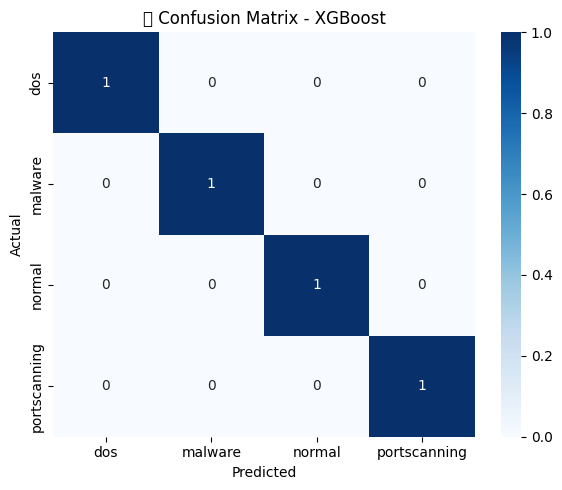

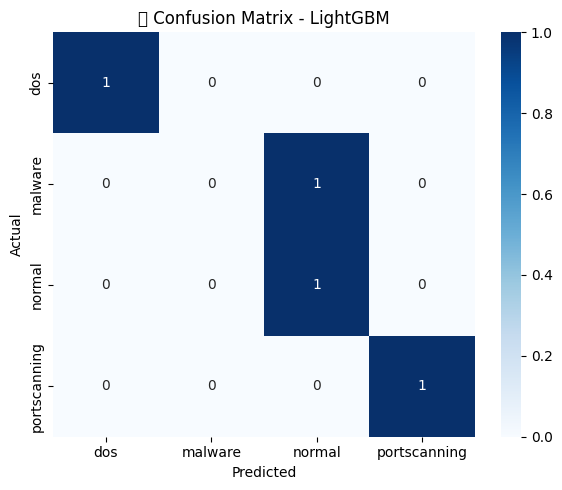

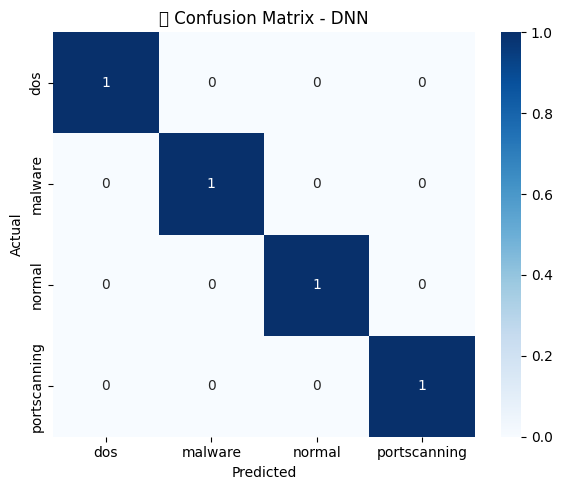


🎯 Top Predictions for Model: Logistic Regression
Sample  1:                       dos → dos                       | ✓ | Top: dos: 0.96, normal: 0.04, malware: 0.00
Sample  2:                   malware → malware                   | ✓ | Top: malware: 1.00, portscanning: 0.00, normal: 0.00
Sample  3:                    normal → normal                    | ✓ | Top: normal: 1.00, portscanning: 0.00, dos: 0.00
Sample  4:              portscanning → portscanning              | ✓ | Top: portscanning: 0.93, normal: 0.07, dos: 0.00

🎯 Top Predictions for Model: Decision Tree
Sample  1:                       dos → dos                       | ✓ | Top: dos: 1.00, malware: 0.00, normal: 0.00
Sample  2:                   malware → malware                   | ✓ | Top: malware: 1.00, dos: 0.00, normal: 0.00
Sample  3:                    normal → normal                    | ✓ | Top: normal: 1.00, dos: 0.00, malware: 0.00
Sample  4:              portscanning → portscanning              | ✓ | Top: portsc

In [9]:
# ===================== Evaluate One Model =====================
def evaluate_model_on_json(model_name, input_data):
    scaler, model, le = load_model(model_name)

    X = pd.DataFrame(input_data.values())
    y_true_labels = list(input_data.keys())
    X_scaled = scaler.transform(X)

    try:
        if hasattr(model, "predict_proba"):
            y_pred = model.predict(X_scaled)
            y_proba = model.predict_proba(X_scaled)
        else:
            raw_pred = model.predict(X_scaled)
            if len(raw_pred.shape) == 2 and raw_pred.shape[1] > 1:
                y_proba = raw_pred
                y_pred = np.argmax(y_proba, axis=1)
            else:
                y_pred = raw_pred.astype(int)
                y_proba = np.eye(len(le.classes_))[y_pred].reshape(len(y_pred), -1)
    except Exception as e:
        print(f"❌ Prediction error for {model_name}: {e}")
        return None

    y_pred_labels = le.inverse_transform(y_pred)
    accuracy = accuracy_score(y_true_labels, y_pred_labels)
    f1 = f1_score(y_true_labels, y_pred_labels, average="weighted")

    return {
        "model": model_name,
        "accuracy": accuracy,
        "f1_score": f1,
        "true_labels": y_true_labels,
        "pred_labels": y_pred_labels,
        "probs": y_proba,
        "classes": le.classes_,
    }

# ===================== Visualize All Models =====================
def visualize_all_models(model_list, json_path, models_dir="./models"):
    with open(json_path, "r") as f:
        input_data = json.load(f)

    eval_results = []
    for model_name in model_list:
        print(f"🔍 Evaluating: {model_name}")
        result = evaluate_model_on_json(model_name, input_data)
        if result: eval_results.append(result)

    # === Accuracy & F1-Score Bar Plot ===
    df_score = pd.DataFrame([{
        "Model": r["model"],
        "Accuracy": r["accuracy"],
        "F1-Score": r["f1_score"]
    } for r in eval_results])

    plt.figure(figsize=(10, 5))
    sns.barplot(data=df_score.melt(id_vars="Model"), x="Model", y="value", hue="variable")
    plt.title("📈 Accuracy & F1-Score Comparison")
    plt.xticks(rotation=30)
    plt.ylim(0, 1.05)
    plt.tight_layout()
    plt.show()

    # === Confusion Matrices ===
    for r in eval_results:
        cm = confusion_matrix(r["true_labels"], r["pred_labels"], labels=r["classes"])
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                    xticklabels=r["classes"], yticklabels=r["classes"])
        plt.title(f"📊 Confusion Matrix - {r['model']}")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.tight_layout()
        plt.show()

    # === Top 3 Class Probabilities ===
    for r in eval_results:
        print(f"\n🎯 Top Predictions for Model: {r['model']}")
        for i, (actual, predicted) in enumerate(zip(r["true_labels"], r["pred_labels"])):
            top_probs = sorted(
                [(label, prob) for label, prob in zip(r["classes"], r["probs"][i])],
                key=lambda x: x[1], reverse=True
            )[:3]
            top_str = ", ".join([f"{lbl}: {p:.2f}" for lbl, p in top_probs])
            match = "✓" if actual == predicted else "✗"
            print(f"Sample {i+1:>2}: {actual:>25} → {predicted:<25} | {match} | Top: {top_str}")

    # === Final Summary: 100% Accurate Models ===
    perfect_models = []
    for r in eval_results:
        matches = [pred == true for pred, true in zip(r["pred_labels"], r["true_labels"])]
        if all(matches):
            perfect_models.append(r["model"])

    print("\n✅ =============================")
    print("✅ Models with 100% Accuracy on test.json")
    print("✅ =============================")
    if perfect_models:
        for m in perfect_models:
            print(f"  ✅ {m}")
    else:
        print("  ❌ No model achieved 100% accuracy.")


# ===================== Run It All =====================
model_list = [
    "Logistic Regression", "Decision Tree", "Random Forest",
    "XGBoost", "LightGBM", "DNN"
]

visualize_all_models(model_list, json_path="./test.json")


In [44]:
# === Step 1: Load model, scaler, and label encoder ===
from tensorflow.keras.models import load_model as load_keras_model

scaler, model, le = load_model("Random Forest")  # le = LabelEncoder
# scaler, model, le = load_model("svc")
# scaler, model, le = load_model("dnn")

# === Step 2: Load the input JSON data ===
with open(f"./test.json", "r") as f:
    input_data = json.load(f)

# === Step 3: Function to predict for a single sample ===
def predict_threat(threat_type):
    """Predict threat for a specific sample from the input data"""
    if threat_type not in input_data:
        print(f"❌ Error: '{threat_type}' not found in input data")
        return

    sample_data = input_data[threat_type]
    input_df = pd.DataFrame([sample_data])
    input_scaled = scaler.transform(input_df)

    # Prediction logic based on model type
    if hasattr(model, "predict_proba"):
        y_pred = model.predict(input_scaled)
        y_proba = model.predict_proba(input_scaled)
    else:
        y_pred_raw = model.predict(input_scaled)
        if len(y_pred_raw.shape) == 2 and y_pred_raw.shape[1] > 1:
            y_proba = y_pred_raw
            y_pred = [np.argmax(y_pred_raw[0])]
        else:
            y_pred = [int(y_pred_raw[0])]
            y_proba = np.eye(len(le.classes_))[y_pred[0]].reshape(1, -1)

    predicted_class = y_pred[0]
    threat_label = le.inverse_transform([predicted_class])[0]

    # Output
    print(f"\n=== Prediction for '{threat_type}' ===")
    print("Predicted Class ID:", predicted_class)
    print("Predicted Threat Type:", threat_label)
    print("Actual Threat Type:", threat_type)
    print("Prediction Correct:", threat_label == threat_type)

    print("\nClass Probabilities:")
    for idx, prob in enumerate(y_proba[0]):
        class_name = le.inverse_transform([idx])[0]
        print(f" {idx} - {class_name}: {prob:.4f}")

# === Step 4: Function to predict all samples ===
def predict_all_threats():
    """Predict for all samples in the input data"""
    print("=== Predicting all threat types ===\n")
    for threat_type in input_data.keys():
        predict_threat(threat_type)

# === Step 5: Batch prediction with summary ===
def batch_predict():
    """Convert all samples to DataFrame and predict in batch"""
    samples = []
    labels = []

    for threat_type, features in input_data.items():
        samples.append(features)
        labels.append(threat_type)

    input_df = pd.DataFrame(samples)
    input_scaled = scaler.transform(input_df)

    if hasattr(model, "predict_proba"):
        y_pred = model.predict(input_scaled)
        y_proba = model.predict_proba(input_scaled)
    else:
        y_pred_raw = model.predict(input_scaled)
        if len(y_pred_raw.shape) == 2 and y_pred_raw.shape[1] > 1:
            y_proba = y_pred_raw
            y_pred = np.argmax(y_proba, axis=1)
        else:
            y_pred = y_pred_raw.astype(int)
            y_proba = np.eye(len(le.classes_))[y_pred].reshape(len(y_pred), -1)

    print("\n=== Batch Prediction Results ===")
    for i, (actual, predicted_id) in enumerate(zip(labels, y_pred)):
        predicted_label = le.inverse_transform([predicted_id])[0]
        match = "✓" if actual == predicted_label else "✗"
        print(f"Sample {i+1}: {actual} → Predicted: {predicted_label} (ID: {predicted_id}) - {match}")

        top_probs = [
            f"{le.inverse_transform([j])[0]}: {prob:.3f}"
            for j, prob in enumerate(y_proba[i]) if prob > 0.1
        ]
        print("  Top probabilities:", ", ".join(top_probs))

# === Example Usage ===
if __name__ == "__main__":
    # predict_threat("Web Attack - Sql Injection")
    # predict_all_threats()
    batch_predict()


=== Batch Prediction Results ===
Sample 1: dos → Predicted: dos (ID: 0) - ✓
  Top probabilities: dos: 1.000
Sample 2: malware → Predicted: malware (ID: 1) - ✓
  Top probabilities: malware: 1.000
Sample 3: normal → Predicted: normal (ID: 2) - ✓
  Top probabilities: normal: 1.000
Sample 4: portscanning → Predicted: portscanning (ID: 3) - ✓
  Top probabilities: portscanning: 1.000


#### Explainability metrics report

In [10]:
_, model2, _ = load_model("Random Forest")

In [27]:
import lime.lime_tabular
from scipy.stats import spearmanr, kendalltau
import warnings
warnings.filterwarnings("ignore")


# === Mapping Metric Scores to Qualitative Ratings ===
def map_rating(metric, value):
    if metric == "faithfulness":
        if value >= 0.9: return "High"
        elif value >= 0.7: return "Moderate–High"
        elif value >= 0.5: return "Moderate"
        else: return "Low"
    if metric == "stability":
        if value < 0.1: return "High"
        elif value < 0.2: return "Moderate"
        else: return "Low"
    if metric == "consistency":
        if value >= 0.85: return "High"
        elif value >= 0.7: return "Moderate–High"
        elif value >= 0.5: return "Moderate"
        else: return "Low"
    if metric == "complexity":
        if value <= 5: return "Low"
        elif value <= 10: return "Moderate"
        else: return "High"
    if metric == "sensitivity":
        if value < 1.0: return "High"
        elif value < 3.0: return "Moderate"
        else: return "Low"
    if metric == "coverage":
        if value >= 0.99: return "High"
        elif value >= 0.9: return "Moderate–High"
        elif value >= 0.8: return "Moderate"
        else: return "Low"


# === Metric Computation Functions ===
def compute_faithfulness(model, input_scaled, shap_values, predicted_label, top_k=15):
    base_pred = model.predict_proba(input_scaled)[0]
    importance_order = np.argsort(-np.abs(shap_values[0]))
    drops, shap_sums = [], []

    for k in range(1, top_k + 1):
        modified = input_scaled.copy()
        modified[0, importance_order[:k]] = 0
        new_pred = model.predict_proba(modified)[0]
        drop = base_pred[predicted_label] - new_pred[predicted_label]
        drops.append(drop)
        shap_sums.append(np.sum(np.abs(shap_values[0][importance_order[:k]])))

    correlation, _ = spearmanr(shap_sums, drops)
    return correlation


def compute_stability(explainer, input_scaled, n=10, noise_std=0.01):
    base_shap = explainer(input_scaled).values[0]
    deviations = []

    for _ in range(n):
        perturbed = input_scaled + np.random.normal(0, noise_std, input_scaled.shape)
        shap_perturbed = explainer(perturbed).values[0]
        diff = np.linalg.norm(base_shap - shap_perturbed)
        deviations.append(diff)

    return np.std(deviations)


def compute_consistency(shap1, shap2):
    r1 = np.argsort(-np.abs(shap1[0]))
    r2 = np.argsort(-np.abs(shap2[0]))
    tau, _ = kendalltau(r1, r2)
    return tau


def compute_complexity(shap_values, threshold=0.01):
    return int(np.sum(np.abs(shap_values[0]) > threshold))


def compute_sensitivity(input_scaled, explainer, noise_std=0.01):
    x1 = input_scaled.copy()
    x2 = input_scaled + np.random.normal(0, noise_std, input_scaled.shape)

    shap1 = explainer(x1).values[0]
    shap2 = explainer(x2).values[0]

    delta_shap = np.linalg.norm(shap1 - shap2)
    delta_input = np.linalg.norm(x1 - x2)
    return delta_shap / delta_input


def compute_coverage(explainer, X, limit=100):
    explained = 0
    for i in range(min(len(X), limit)):
        try:
            explainer(X[i:i+1])
            explained += 1
        except:
            continue
    return explained / min(len(X), limit)


# === Main Function: Generate Explainability Report ===
def generate_explainability_report(model, scaler, le, input_json, training_df, model2=None):
    feature_names = list(input_json.keys())
    input_df = pd.DataFrame([input_json])
    input_scaled = scaler.transform(input_df)
    training_scaled = scaler.transform(training_df)

    # Get predictions
    y_proba = model.predict_proba(input_scaled)
    predicted_label = np.argmax(y_proba[0])
    predicted_class_name = le.inverse_transform([predicted_label])[0]

    # SHAP Explainer
    explainer_shap = shap.Explainer(model, training_scaled, feature_names=feature_names)
    shap_input = explainer_shap(input_scaled)
    shap_train = explainer_shap(training_scaled)

    # === Handle Multi-Class Output ===
    if hasattr(shap_input, 'values') and shap_input.values.ndim == 3:
        shap_input_values = shap_input.values[0, :, predicted_label].reshape(1, -1)
        shap_train_values = shap_train.values[:, :, predicted_label]
    else:
        shap_input_values = shap_input.values
        shap_train_values = shap_train.values

    # === Compute Metrics ===
    metrics = {}

    try:
        metrics["faithfulness"] = compute_faithfulness(model, input_scaled, shap_input_values, predicted_label)
    except:
        metrics["faithfulness"] = np.nan

    try:
        metrics["stability"] = compute_stability(explainer_shap, input_scaled)
    except:
        metrics["stability"] = np.nan

    try:
        metrics["complexity"] = compute_complexity(shap_input_values)
    except:
        metrics["complexity"] = np.nan

    try:
        metrics["sensitivity"] = compute_sensitivity(input_scaled, explainer_shap)
    except:
        metrics["sensitivity"] = np.nan

    try:
        metrics["coverage"] = compute_coverage(explainer_shap, training_scaled)
    except:
        metrics["coverage"] = np.nan

    if model2:
        try:
            explainer2 = shap.Explainer(model2, training_scaled, feature_names=feature_names)
            shap2 = explainer2(input_scaled)
            if shap2.values.ndim == 3:
                shap2_values = shap2.values[0, :, predicted_label].reshape(1, -1)
            else:
                shap2_values = shap2.values
            metrics["consistency"] = compute_consistency(shap_input_values, shap2_values)
        except:
            metrics["consistency"] = np.nan
    else:
        metrics["consistency"] = np.nan

    # === Build Final Report Table ===
    table = pd.DataFrame([
        {
            "Metric": key.capitalize(),
            "Value": f"{value:.4f}" if isinstance(value, float) and not np.isnan(value) else "N/A",
            "Rating": map_rating(key, value) if not np.isnan(value) else "N/A"
        } for key, value in metrics.items()
    ])

    print("\n📋 Explainability Metrics Report - SIMARGL")
    print("=" * 50)
    print(table.to_string(index=False))
    print("=" * 50)

    return table


In [12]:
table = generate_explainability_report(model, scaler, le, input_json, training_df,model2=model2)


📋 Explainability Metrics Report - SIMARGL
      Metric   Value   Rating
Faithfulness  0.6982 Moderate
   Stability  0.0222     High
  Complexity     N/A     High
 Sensitivity 10.1461      Low
    Coverage  1.0000     High
 Consistency  1.0000     High
